# Deep Q-learning (DQN)

This notebook describes the DQN reinforcement learning (RL) algorithm. 


## Environment 

We will train an agent to balance a vertical pole on a cart. This is a classic environment in RL, named CartPole. See the environment description [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to get more details about the environment.

In [1]:
# Library imports
import gymnasium as gym
import numpy as np
import utils.envs, utils.seed, utils.buffers, utils.torch, utils.common
import torch
import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



Initialize a set of hyperparameters

In [2]:
# Constants
SEEDS = [1,2,3]
t = utils.torch.TorchHelper()
DEVICE = t.device
OBS_N = 4               # State space size
ACT_N = 2               # Action space size
MINIBATCH_SIZE = 10     # How many examples to sample per train step
GAMMA = 0.99            # Discount factor in episodic reward objective
LEARNING_RATE = 5e-4    # Learning rate for Adam optimizer
TRAIN_AFTER_EPISODES = 10   # Just collect episodes for these many episodes
TRAIN_EPOCHS = 5        # Train for these many epochs every time
BUFSIZE = 10000         # Replay buffer size
EPISODES = 300          # Total number of episodes to learn over
TEST_EPISODES = 1       # Test episodes after every train episode
HIDDEN = 512            # Hidden nodes
TARGET_UPDATE_FREQ = 10 # Target network update frequency
STARTING_EPSILON = 1.0  # Starting epsilon
STEPS_MAX = 10000       # Gradually reduce epsilon over these many steps
EPSILON_END = 0.01      # At the end, keep epsilon at this value

# Global variables
EPSILON = STARTING_EPSILON
Q = None



Create the Cartpole Environment from Gym

In [3]:
# Create environment
# Create replay buffer
# Create network for Q(s, a)
# Create target network
# Create optimizer
def create_everything(seed):

    utils.seed.seed(seed)
    env = gym.make("CartPole-v0")
    env.reset(seed=seed) ####
    test_env = gym.make("CartPole-v0")
    test_env.reset(seed=10+seed) ####
    buf = utils.buffers.ReplayBuffer(BUFSIZE)
    Q = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    Qt = torch.nn.Sequential(
        torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN, ACT_N)
    ).to(DEVICE)
    OPT = torch.optim.Adam(Q.parameters(), lr = LEARNING_RATE)
    return env, test_env, buf, Q, Qt, OPT



Implementing a function to update the target network

In [4]:
# Update a target network using a source network
def update(target, source):
    for tp, p in zip(target.parameters(), source.parameters()):
        tp.data.copy_(p.data)



Implementing a function for the policy

In [5]:
# Create epsilon-greedy policy
def policy(env, obs):

    global EPSILON, Q

    obs = t.f(obs).view(-1, OBS_N)  # Convert to torch tensor
    
    # With probability EPSILON, choose a random action
    # Rest of the time, choose argmax_a Q(s, a) 
    if np.random.rand() < EPSILON:
        action = np.random.randint(ACT_N)
    else:
        qvalues = Q(obs)
        action = torch.argmax(qvalues).item()
    
    # Epsilon update rule: Keep reducing a small amount over
    # STEPS_MAX number of steps, and at the end, fix to EPSILON_END
    EPSILON = max(EPSILON_END, EPSILON - (1.0 / STEPS_MAX))
    # print(EPSILON)

    return action






Function to update the evaluation network (and target network through the previous update function)

In [6]:
# Update networks
def update_networks(epi, buf, Q, Qt, OPT):
    
    # Sample a minibatch (s, a, r, s', d)
    # Each variable is a vector of corresponding values
    S, A, R, S2, D = buf.sample(MINIBATCH_SIZE, t)
    
    # Get Q(s, a) for every (s, a) in the minibatch
    qvalues = Q(S).gather(1, A.view(-1, 1)).squeeze()

    # Get max_a' Qt(s', a') for every (s') in the minibatch
    q2values = torch.max(Qt(S2), dim = 1).values

    # If done, 
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (0)
    # If not done,
    #   y = r(s, a) + GAMMA * max_a' Q(s', a') * (1)       
    targets = R + GAMMA * q2values * (1-D)

    # Detach y since it is the target. Target values should
    # be kept fixed.
    loss = torch.nn.MSELoss()(targets.detach(), qvalues)

    # Backpropagation
    OPT.zero_grad()
    loss.backward()
    OPT.step()

    # Update target network every few steps
    if epi % TARGET_UPDATE_FREQ == 0:
        update(Qt, Q)

    return loss.item()


Train function to train a DQN agent in Cartpole

In [7]:
# Play episodes
# Training function
def train(seed):

    global EPSILON, Q
    print("Seed=%d" % seed)

    # Create environment, buffer, Q, Q target, optimizer
    env, test_env, buf, Q, Qt, OPT = create_everything(seed)

    # epsilon greedy exploration
    EPSILON = STARTING_EPSILON

    testRs = []
    last25testRs = []
    print("Training:")
    pbar = tqdm.trange(EPISODES)
    for epi in pbar:

        # Play an episode and log episodic reward
        S, A, R = utils.envs.play_episode_rb(env, policy, buf)
        
        # Train after collecting sufficient experience
        if epi >= TRAIN_AFTER_EPISODES:

            # Train for TRAIN_EPOCHS
            for tri in range(TRAIN_EPOCHS): 
                update_networks(epi, buf, Q, Qt, OPT)

        # Evaluate for TEST_EPISODES number of episodes
        Rews = []
        for epj in range(TEST_EPISODES):
            S, A, R = utils.envs.play_episode(test_env, policy, render = False)
            Rews += [sum(R)]
        testRs += [sum(Rews)/TEST_EPISODES]

        # Update progress bar
        last25testRs += [sum(testRs[-25:])/len(testRs[-25:])]
        pbar.set_description("R25(%g)" % (last25testRs[-1]))

    # Close progress bar, environment
    pbar.close()
    print("Training finished!")
    env.close()

    return last25testRs


Running training and plotting performances

Seed=1
Training:


R25(156.72): 100%|████████████████████████████| 300/300 [00:17<00:00, 16.82it/s]


Training finished!
Seed=2
Training:


R25(156.72): 100%|████████████████████████████| 300/300 [00:17<00:00, 17.16it/s]


Training finished!
Seed=3
Training:


R25(153.84): 100%|████████████████████████████| 300/300 [00:16<00:00, 17.86it/s]


Training finished!


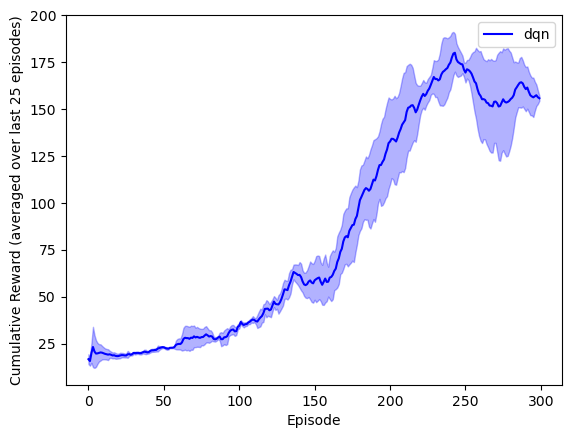

In [8]:
# Plot mean curve and (mean-std, mean+std) curve with some transparency
def plot_arrays(vars, color, label):
    mean = np.mean(vars, axis=0)
    std = np.std(vars, axis=0)
    plt.plot(range(len(mean)), mean, color=color, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, 0), np.minimum(mean+std,200), color=color, alpha=0.3)

if __name__ == "__main__":

    # Train for different seeds
    curves = []
    for seed in SEEDS:
        curves += [train(seed)]

    # Plot the curve for the given seeds
    plot_arrays(curves, 'b', 'dqn')
    plt.legend(loc='best')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward (averaged over last 25 episodes)')
    plt.show()

## Part 3: DQN 

a) Modify and run the code for CartPole DQN to produce a graph where the
y-axis is the running average of 25 episodes for the cumulative rewards
obtained at each episode and the x-axis is the number of episodes up
to a minimum of 300 episodes. **The graph should contain 3 curves
corresponding to updating the target network every 1, 10 (default) and 30 
training step(s).** To reduce stochasticity in the results, report curves
that are the average of atleast 3 runs of the given code (with different
random seeds). Based on the results, **explain the impact of the target
network and relate the target network to value iteration** (worth 20%).

b) Modify and run the code for CartPole DQN to produce a graph where the
y-axis is the running average of 25 episodes for the cumulative rewards
obtained at each episode and the x-axis is the number of episodes up
to a minimum of 300 episodes. **The graph should contain 3 curves
corresponding to sampling mini-batches of 1, 10 (default) and 30
experience(s) from the replay buffer.** To reduce stochasticity in the results,
report curves that are the average of at least 3 runs of the given code (with
different random seeds). Based on the results, **explain the impact of the
replay buffer and explain the difference between using the replay buffer
and exact gradient descent** (worth 20%).